# Data Preprocessing

In [123]:
import os
import re
import warnings
# Data manipulation
import numpy as np
import pandas as pd
# Visualizatoin
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.covariance import MinCovDet
# Inference
from scipy.stats import chi2
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency

# Pandas configuration
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

warnings.filterwarnings('ignore')

## Load Data

In [8]:
df = pd.read_csv('../data/raw/loan_data.csv', sep=',')
# Adjust columns names
df.columns = [col.replace('.', '_') for col in df.columns.values]
# Rename target column
df = df.rename(columns={'not_fully_paid': 'default'})

## Train and Test Sets

Before starting data preprocessin, we split the data set into 3 sets:
- **Training:** this set contains 70% of the data and will be use to train the model<br>
- **Validation:** this set contains 15% of the data and will be use to tune hyperparams<br>
- **Test:** this set contains 15% of the data and will be use to select the final model

In [316]:
X = df.drop('default', axis=1)
y = df.default

x_train_temp, x_test, y_train_temp, y_test = train_test_split(X, y, 
                                                    test_size=0.15,
                                                    stratify=y,
                                                    random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp,
                                                  test_size=0.15,
                                                  stratify=y_train_temp,
                                                  random_state=42
                                                  )

Check all datasets has the same distribution for the target variable

In [23]:
print("Original distribution")
print(df.default.value_counts(normalize=True))
print("\nTrain set distribution")
print(y_train.value_counts(normalize=True))
print("\nValidation set distribution")
print(y_val.value_counts(normalize=True))
print("\nTest set distribution")
print(y_test.value_counts(normalize=True))

Original distribution
default
0    0.839946
1    0.160054
Name: proportion, dtype: float64

Train set distribution
default
0    0.840006
1    0.159994
Name: proportion, dtype: float64

Validation set distribution
default
0    0.839607
1    0.160393
Name: proportion, dtype: float64

Test set distribution
default
0    0.839944
1    0.160056
Name: proportion, dtype: float64


## Auxiliary functions for preprocessing

In [119]:
def bivariated_plot(df, x, y, hue=None, ylabel=None, title=None,
                    legend_title=None, xlabel=None, kind='box', figheight=5, 
                    figwidth=10):
    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    if kind == 'box':
        g = sns.boxplot(data=df, y=y, x=x, hue=hue, ax=ax)
    elif kind == 'boxen':
        g = sns.boxenplot(data=df, y=y, x=x, hue=hue, ax=ax)
    elif kind == 'scatter':
        g = sns.scatterplot(data=df, y=y, x=x, hue=hue, s=100, ax=ax)
    else:
        g = sns.kdeplot(data=df, x=y, fill=True, ax=ax)
        sns.rugplot(data=df, x=y, color='red', alpha=0.1, ax=ax)
    
    plt.title(title, size=20)
    plt.ylabel(ylabel, size=18)
    plt.yticks(fontsize=16)
    plt.xlabel(xlabel, size=18)
    plt.xticks(fontsize=16)
    plt.legend(title=legend_title, fontsize='50')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.show()
    
def woe_cat_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

def woe_num_discrete(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.axhline(0, linestyle='--', color='r', lw=2.5)
    
def text_normalized(text: str) -> str:
    """Funcion para quitar tildes de las vocales
    Args:
        text (str): cadena de texto con tildes
    Returns:
        str: cadena de texto sin tildes
    """    
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        text = text.replace(a, b).replace(a.upper(), b.upper())
    return text

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        # print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

def cov(data, scaled=False, scaler='standar', robust=False):
    df = data.copy()
    df1 = pd.DataFrame(columns=['variable', 'cov'])
    
    if robust:
        i = 0
        for col in df.columns:
            q1, q3 = np.percentile(df[col], [25, 75])
            iqr = q3 - q1
            median = df[col].median()
            if median == 0:
                cov = 0
            else:
                cov = iqr / median
            df1.loc[i] = [col, cov]
            i+= 1
    else:
        if scaled:
            if scaler == 'standar':
                df = df.apply(lambda row: (row - row.mean())/row.std(), axis=1)
            else:
                df = df.apply(lambda row: (row - row.min())/(row.max() - row.min()), axis=1)
        
        i = 0
        for col in df.columns:
            mean = np.mean(df[col].dropna())
            std_dev = np.std(df[col].dropna())
            if mean == 0:
                cov = 0
            else:
                cov = std_dev / mean
            df1.loc[i] = [col, cov]
            i+= 1
        
    df1 = df1.sort_values(by='cov', ascending=False)
    df1 = df1.reset_index(drop=True)
        
    return df1
        
def dummy_creation(df, columns_list):
    """Funcion para crear variables dummies
    """
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df


## Preprocessing

### Numerical variables

In [30]:
num_df = x_train.drop('purpose', axis=1)

In [41]:
(num_df
 .describe()
 .T
 .style
 .format({'count': '{:.0f}',
          'mean': '{:.2f}',
          'std': '{:.2f}',
          'min': '{:.2f}',
          '25%': '{:.2f}',
          '50%': '{:.2f}',
          '75%': '{:.2f}',
          'max': '{:.2f}'
          })
 )

,count,mean,std,min,25%,50%,75%,max
credit_policy,6919,0.80,0.40,0.00,1.00,1.00,1.00,1.00
int_rate,6919,0.12,0.03,0.06,0.10,0.12,0.14,0.22
installment,6919,319.22,206.24,15.67,163.70,269.07,437.72,940.14
log_annual_inc,6919,10.94,0.61,7.55,10.57,10.92,11.29,14.18
dti,6919,12.61,6.90,0.00,7.16,12.58,18.03,29.96
fico,6919,711.02,38.07,612.00,682.00,707.00,737.00,827.00
days_with_cr_line,6919,4544.48,2492.79,180.04,2790.00,4110.04,5700.04,17639.96
revol_bal,6919,17242.54,34909.10,0.00,3204.50,8613.00,18341.00,1207359.00
revol_util,6919,46.94,29.13,0.00,22.75,46.40,71.20,119.00
inq_last_6mths,6919,1.56,2.14,0.00,0.00,1.00,2.00,31.00


In [76]:
x_train.purpose.value_counts(normalize=True) * 100

purpose
debt_consolidation    41.263188
all_other             24.093077
credit_card           13.065472
small_business         6.749530
home_improvement       6.576095
major_purchase         4.567134
educational            3.685504
Name: proportion, dtype: float64

## Outlier Detection

For outlier detection the Mahalanobis distance is used

In [318]:
outlier_df = x_train.select_dtypes(exclude=['object', 'category'])
outlier_df.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
3950,1,0.1284,268.95,10.714418,8.32,712,2100.000000,9572,76.6,0,0,0
7112,1,0.1645,583.73,11.472103,15.10,667,4620.041667,19257,92.6,1,0,0
610,1,0.0976,482.32,10.165852,5.77,777,4560.041667,3050,2.9,1,0,0
966,1,0.1229,213.46,10.463103,20.78,687,4620.000000,9408,64.0,1,0,0
4794,1,0.0894,254.18,11.652687,2.70,762,6900.000000,5914,15.9,4,0,0


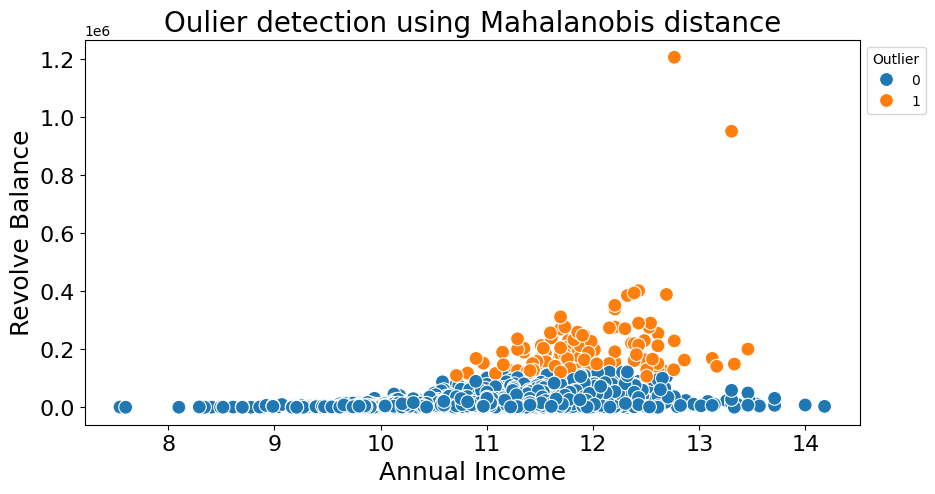

In [319]:
target = y_train

mcd = MinCovDet().fit(num_df)
mahadist = mcd.mahalanobis(num_df)
cutoff = np.percentile(mahadist, 98)
# cutoff = chi2.ppf(0.95, num_df.shape[1])
outlier_df['maha_out'] = mahadist
outlier_df.maha_out = [1 if mcd > cutoff else 0 for mcd in outlier_df.maha_out]

bivariated_plot(outlier_df,#.query("maha_out == 0"),
                y='revol_bal',
                x='log_annual_inc',
                hue='maha_out',
                kind='scatter',
                xlabel='Annual Income',
                ylabel='Revolve Balance',
                title='Oulier detection using Mahalanobis distance',
                legend_title='Outlier',
                figwidth=10,
                figheight=5)

## Feature Selection

For selecting variables, many criteria such us informatio value, chi-square test, anova test and the results from the exploratoy analysis are taken into account

### Categorical Variables

#### Information Value

In [126]:
cat_df = x_train.select_dtypes(include=['object', 'category']).copy()

# Invertir valores de clases para calcular y graficar WoE
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

cat_df = x_train.select_dtypes(include=['object', 'category'])
cat_df['bad'] = target
iv, woe = iv_woe(data=cat_df, target='bad', bins=10, show_woe=False)

iv.columns = [col.lower() for col in iv.columns]
iv.loc[iv.iv <= 0.02,'predictividad'] = 'None'
iv.loc[(iv.iv > 0.02) & (iv.iv <= 0.1),'predictividad'] = 'Weak'
iv.loc[(iv.iv > 0.1) & (iv.iv <= 0.3),'predictividad'] = 'Medium'
iv.loc[(iv.iv > 0.3) & (iv.iv <= 0.5),'predictividad'] = 'Strong'
iv.loc[iv.iv > 0.5,'predictividad'] = 'Suspiciously strong'
iv.sort_values(by='iv', ascending=False)

,variable,iv,predictividad
0,purpose,0.07901,Weak


#### Chi squared test

In [113]:
cat_df = x_train.select_dtypes(include=['object', 'category'])
cat_df['bad'] = y_train

chi2_check = {}
for column in cat_df:
    if column == 'bad':
        pass
    else:
        chi, p, dof, ex = chi2_contingency(pd.crosstab(cat_df.bad, cat_df[column]))
        chi2_check.setdefault('Feature',[]).append(column)
        chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data=chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result['significant'] = np.where(chi2_result['p-value'] < 0.05, 'yes', 'no')
chi2_result

,Feature,p-value,significant
0,purpose,0.0,yes


### Numerical Variables

#### Anova Test

In [125]:
# Calcular estadistico F y p-value
F_statistic, p_values = f_classif(num_df, y_train)

# DF
ANOVA_F_table = pd.DataFrame(data = {'variable': num_df.columns.values, 
                                     'F-Score': F_statistic, 
                                     'p-value': p_values.round(decimals=10)})
ANOVA_F_table = ANOVA_F_table.reset_index(drop=True)
ANOVA_F_table.sort_values(by = ['F-Score'],
                          ascending = False,
                          ignore_index = True,
                          inplace = True)
ANOVA_F_table = ANOVA_F_table.loc[ANOVA_F_table.variable != 'bad', :]
ANOVA_F_table['significant'] = np.where(ANOVA_F_table['p-value'] < 0.05, 'yes', 'no')

ANOVA_F_table

,variable,F-Score,p-value,significant
1,int_rate,174.070624,0.000000,yes
2,credit_policy,144.943501,0.000000,yes
3,fico,133.501869,0.000000,yes
4,inq_last_6mths,129.023205,0.000000,yes
5,revol_util,45.757721,0.000000,yes
6,revol_bal,20.619445,0.000006,yes
7,installment,17.548604,0.000028,yes
8,pub_rec,16.634476,0.000046,yes
9,dti,8.446555,0.003669,yes
10,log_annual_inc,4.070289,0.043682,yes


#### Information Value

In [127]:
# Invertir valores de clases para calcular y graficar WoE
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0
num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
num_df['bad'] = target
iv, woe = iv_woe(data=num_df, target='bad', bins=10, show_woe=False)

iv.columns = [col.lower() for col in iv.columns]
iv.loc[iv.iv <= 0.02,'predictividad'] = 'None'
iv.loc[(iv.iv > 0.02) & (iv.iv <= 0.1),'predictividad'] = 'Weak'
iv.loc[(iv.iv > 0.1) & (iv.iv <= 0.3),'predictividad'] = 'Medium'
iv.loc[(iv.iv > 0.3) & (iv.iv <= 0.5),'predictividad'] = 'Strong'
iv.loc[iv.iv > 0.5,'predictividad'] = 'Suspiciously strong'
iv.sort_values(by='iv', ascending=False)

,variable,iv,predictividad
0,int_rate,0.239938,Medium
0,fico,0.161819,Medium
0,credit_policy,0.132144,Medium
0,inq_last_6mths,0.131994,Medium
0,revol_util,0.066965,Weak
0,installment,0.030106,Weak
0,revol_bal,0.024866,Weak
0,pub_rec,0.022926,Weak
0,log_annual_inc,0.016012,None
0,dti,0.011323,None


Given the EDA analysis and the tests applied in this secction. The following variables are selected:
- credit_policy 
- int_rate 
- installment 
- dti 
- fico 
- revol_util 
- inq_last_6mths 
- log_annual_inc
- purpose

## Feature Engineering Using WOE

For creating new variables the Weight of Evidence is used.

The variables created using the WoE will be categorical, based on the woe value for each of the variables classes. 
- A WoE near to 0 means that the class is not relevant for predicting the target variable. 
- A positive value of WoE means the variable tends to predict better the negative class of the target variable 
- A negative value of Woe means that the variable tends to predict better the positive class of the target variable. 

In this case the positive class means that the customer will default

We will apply WoE anaylsis for numercial and catgorical variables for defining variable classes for each one of the select variables. Next we will define the base category for each variable, as the base category will be selected the one which has the closest value to zero

Finally we will create pipeline in the modeling, using custom sklearn classes, to apply this transformation to the datasets.

### Categorical Variables

In [117]:
"""
Purposes groups
----------------
small_business
educational | home_improvement (base category)
all_other | debt_consolidation
credit_card
major_purchase

"""

cat_df = x_train.select_dtypes(include=['object', 'category']).copy()

# Invertir valores de clases para calcular y graficar WoE
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

temp_df = woe_cat_discrete(cat_df, 'purpose', target)
temp_df

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,467,0.728051,0.067495,340.0,127.0,0.058500,0.114724,-0.673513,NaN,NaN,0.07901
1,educational,255,0.807843,0.036855,206.0,49.0,0.035444,0.044264,-0.222215,0.079792,0.451297,0.07901
2,home_improvement,455,0.813187,0.065761,370.0,85.0,0.063661,0.076784,-0.187419,0.005344,0.034796,0.07901
3,all_other,1667,0.830834,0.240931,1385.0,282.0,0.238300,0.254743,-0.066723,0.017647,0.120697,0.07901
4,debt_consolidation,2855,0.848687,0.412632,2423.0,432.0,0.416896,0.390244,0.066065,0.017853,0.132788,0.07901
5,credit_card,904,0.883850,0.130655,799.0,105.0,0.137474,0.094851,0.371130,0.035163,0.305064,0.07901
6,major_purchase,316,0.914557,0.045671,289.0,27.0,0.049725,0.024390,0.712319,0.030707,0.341189,0.07901


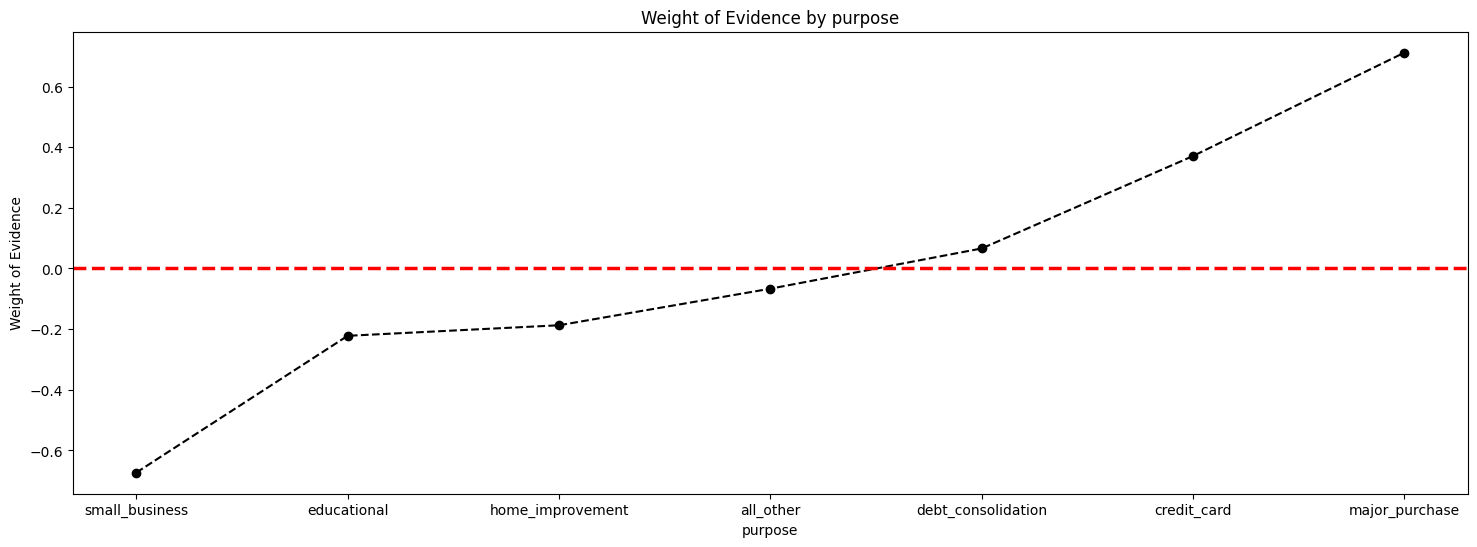

In [120]:
plot_by_woe(temp_df)

### Numerical Variables

#### Int_rate

In [150]:
"""
Int rate ranges
----------------
(0.0, 0.0823]
(0.0823, 0.105]
(0.105, 0.127] (base)
(0.127, 0.149]
(0.149, 0.172]
(0.172, 0.194]
(0.194, 0.216]

"""

num_df['int_rate_rg'] = pd.cut(num_df.int_rate, 7) # 7
temp_df = woe_num_discrete(num_df, 'int_rate_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,int_rate_rg,n_obs,n_good,n_bad,WoE,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(0.0598, 0.0823]",587,562,25,1.454355,8.48,8.48,1,0,1,1
1,"(0.0823, 0.105]",1178,1063,115,0.565647,17.03,25.51,1,1,1,1
2,"(0.105, 0.127]",2120,1775,345,-0.020260,30.64,56.15,1,1,1,1
3,"(0.127, 0.149]",1893,1539,354,-0.188680,27.36,83.51,1,1,1,1
4,"(0.149, 0.172]",876,692,184,-0.333621,12.66,96.17,1,1,1,1
5,"(0.172, 0.194]",215,150,65,-0.822023,3.11,99.28,0,0,1,1
6,"(0.194, 0.216]",50,31,19,-1.168723,0.72,100.00,0,0,1,1


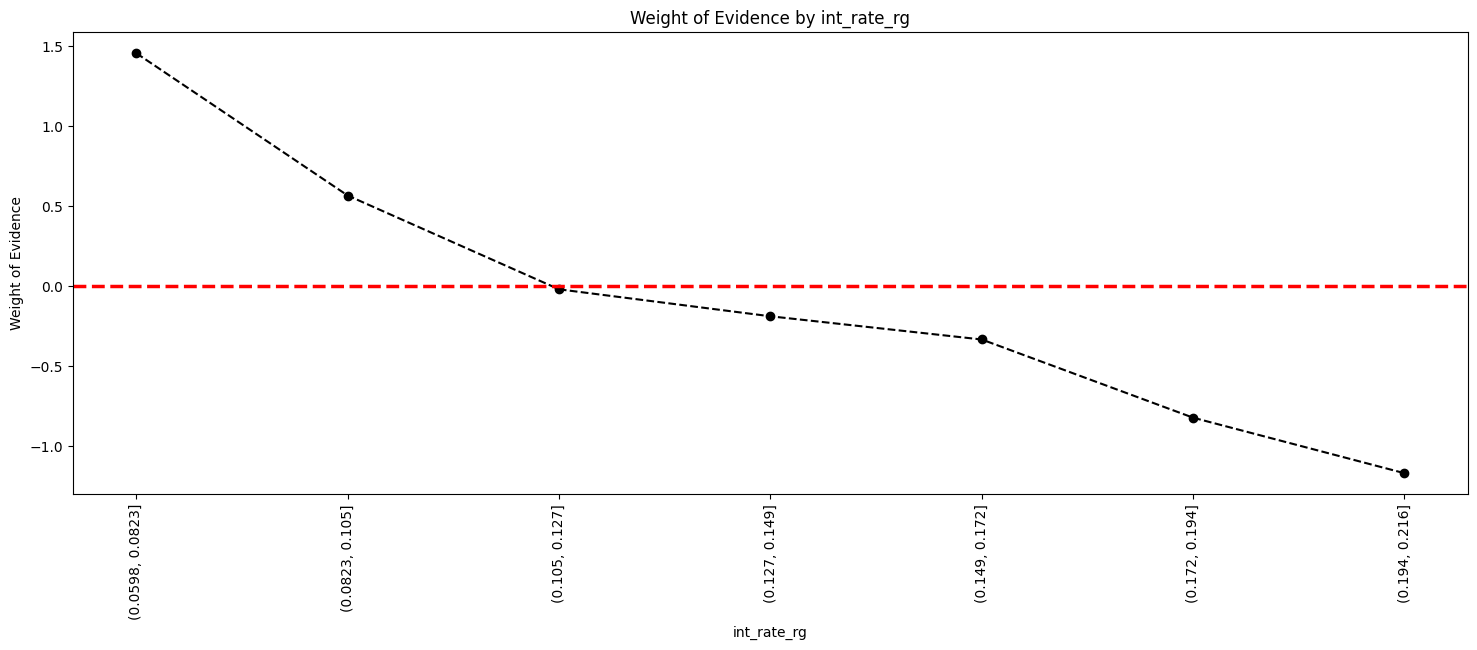

In [151]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

#### installment

In [175]:
"""
Installment ranges
----------------
(0, 147.737]
(147.737, 279.804]
(279.804, 411.871] (Base)
(411.871, 676.006]
(676.006, 808.073]
(808.073, inf]

"""
num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

num_df['installment_rg'] = pd.cut(num_df.installment, 7) # 7
temp_df = woe_num_discrete(num_df, 'installment_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,9,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,installment_rg,n_obs,n_good,n_bad,WoE,diff_prop_good,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(14.746, 147.737]",1421,1212,209,0.099422,nan,20.54,20.54,1,1,1,1
1,"(147.737, 279.804]",2163,1839,324,0.077963,0.002712,31.26,51.80,1,1,1,1
2,"(279.804, 411.871]",1470,1238,232,0.016244,0.008031,21.25,73.05,1,1,1,1
3,"(411.871, 543.939]",877,726,151,-0.088001,0.014355,12.68,85.72,1,1,1,1
4,"(543.939, 676.006]",439,364,75,-0.078605,0.001335,6.34,92.07,1,0,1,1
5,"(676.006, 808.073]",299,242,57,-0.212385,0.019793,4.32,96.39,0,0,1,1
6,"(808.073, 940.14]",250,191,59,-0.483535,0.045365,3.61,100.00,0,0,1,1


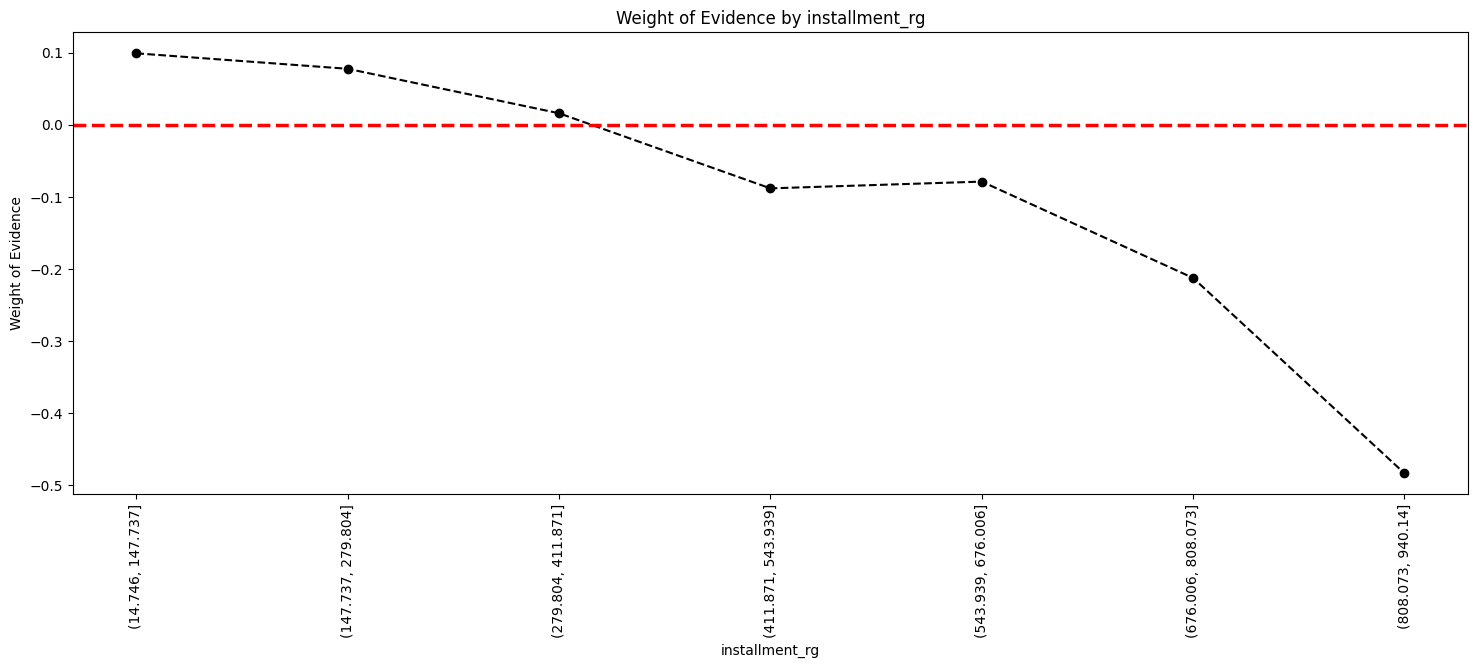

In [176]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

#### log_annual_inc

In [229]:
"""
Log annual income range
------------------------
(0, 10.949] (Base)
(10.949, 12.026]
(12.026, 13.103]
(13.103, inf]
"""

num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

num_df2_temp = num_df.loc[(num_df.log_annual_inc > 9.869), :].copy()
num_df2_temp['log_annual_inc_rg'] = pd.cut(num_df2_temp.log_annual_inc, 4)
temp_df = woe_num_discrete(num_df2_temp, 'log_annual_inc_rg', target)

# num_df['log_annual_inc_rg'] = pd.cut(num_df.log_annual_inc, 20)
# temp_df = woe_num_discrete(num_df, 'log_annual_inc_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,9,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,log_annual_inc_rg,n_obs,n_good,n_bad,WoE,diff_prop_good,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(9.867, 10.949]",3278,2742,536,-0.047269,nan,49.25,49.25,1,1,1,1
1,"(10.949, 12.026]",3115,2657,458,0.078506,0.016484,46.80,96.05,1,1,1,1
2,"(12.026, 13.103]",241,195,46,-0.235219,0.043841,3.62,99.67,0,0,1,1
3,"(13.103, 14.18]",22,16,6,-0.698748,0.081856,0.33,100.00,0,0,1,1


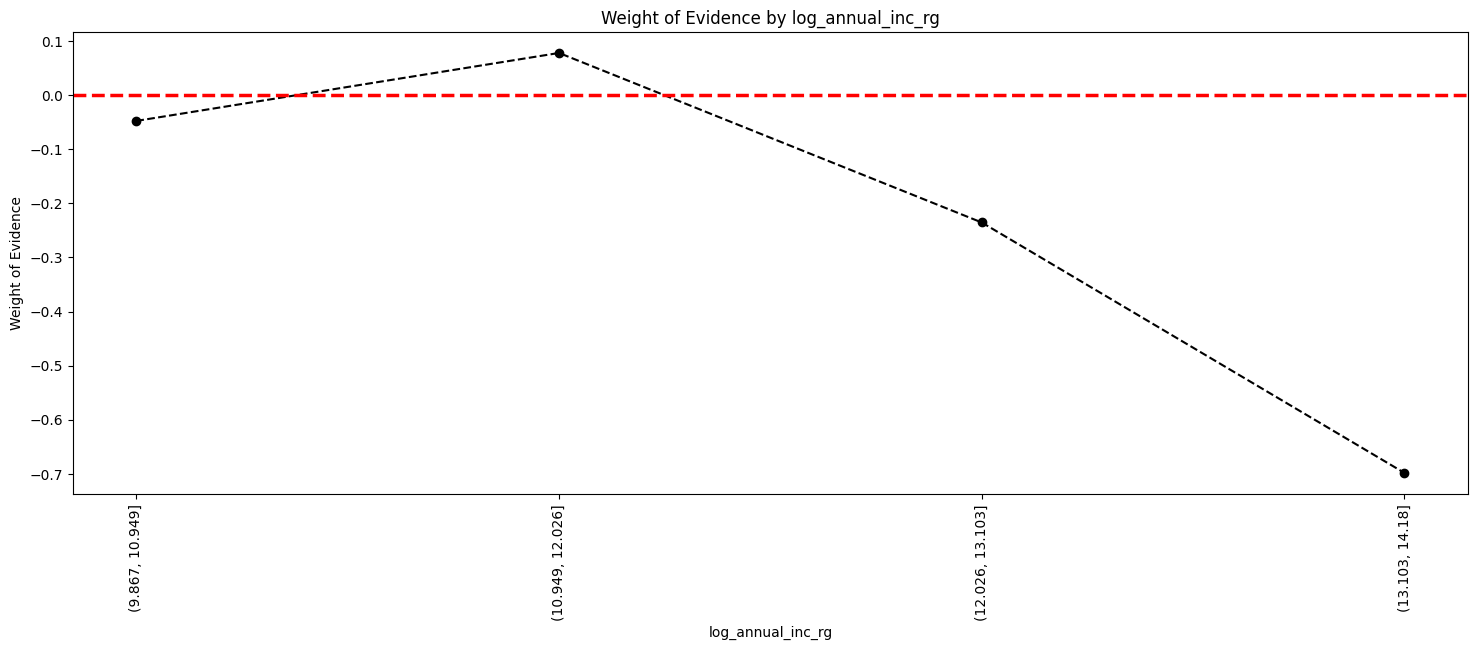

In [230]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

#### dti

In [249]:
"""
dti range
------------------------
(0, 8]
(8, 15] (Base)
(15, 23]
(23, 100]
"""

num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

num_df['dti_rg'] = pd.cut(num_df.dti, 4)
temp_df = woe_num_discrete(num_df, 'dti_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,9,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,dti_rg,n_obs,n_good,n_bad,WoE,diff_prop_good,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(-0.03, 7.49]",1825,1559,266,0.110032,nan,26.38,26.38,1,1,1,1
1,"(7.49, 14.98]",2423,2046,377,0.033126,0.009839,35.02,61.40,1,1,1,1
2,"(14.98, 22.47]",2079,1723,356,-0.081380,0.015644,30.05,91.44,1,1,1,1
3,"(22.47, 29.96]",592,484,108,-0.158317,0.011196,8.56,100.00,1,0,1,1


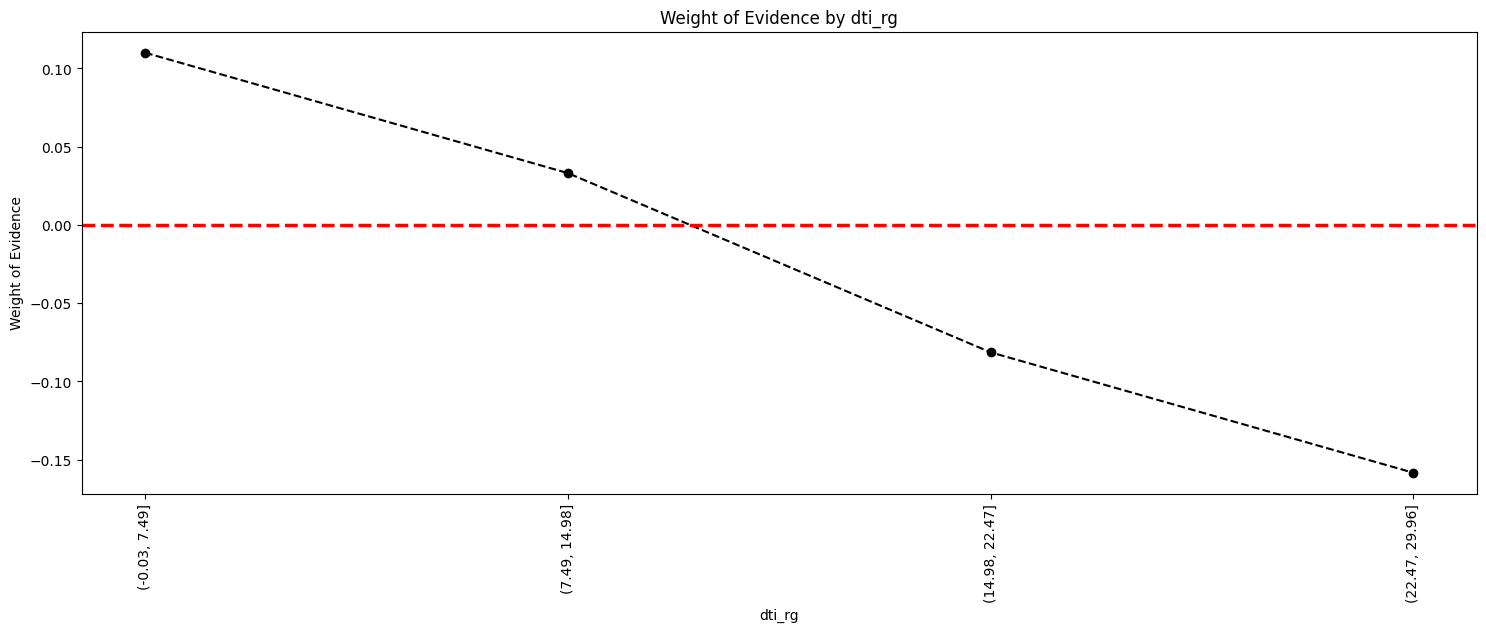

In [250]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

#### fico

In [255]:
"""
Fico range
------------------------
(0, 655]
(655, 698]
(698, 741] (Base)
(741, 784]
(784, 850]
"""

num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

num_df['fico_rg'] = pd.cut(num_df.fico, 5)
temp_df = woe_num_discrete(num_df, 'fico_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,9,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,fico_rg,n_obs,n_good,n_bad,WoE,diff_prop_good,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(611.785, 655.0]",254,181,73,-0.750234,nan,3.67,3.67,0,0,1,1
1,"(655.0, 698.0]",2764,2227,537,-0.235859,0.093118,39.95,43.62,1,1,1,1
2,"(698.0, 741.0]",2289,1930,359,0.023682,0.037447,33.08,76.70,1,1,1,1
3,"(741.0, 784.0]",1310,1192,118,0.654432,0.066761,18.93,95.64,1,1,1,1
4,"(784.0, 827.0]",302,282,20,0.987904,0.023851,4.36,100.00,0,0,1,1


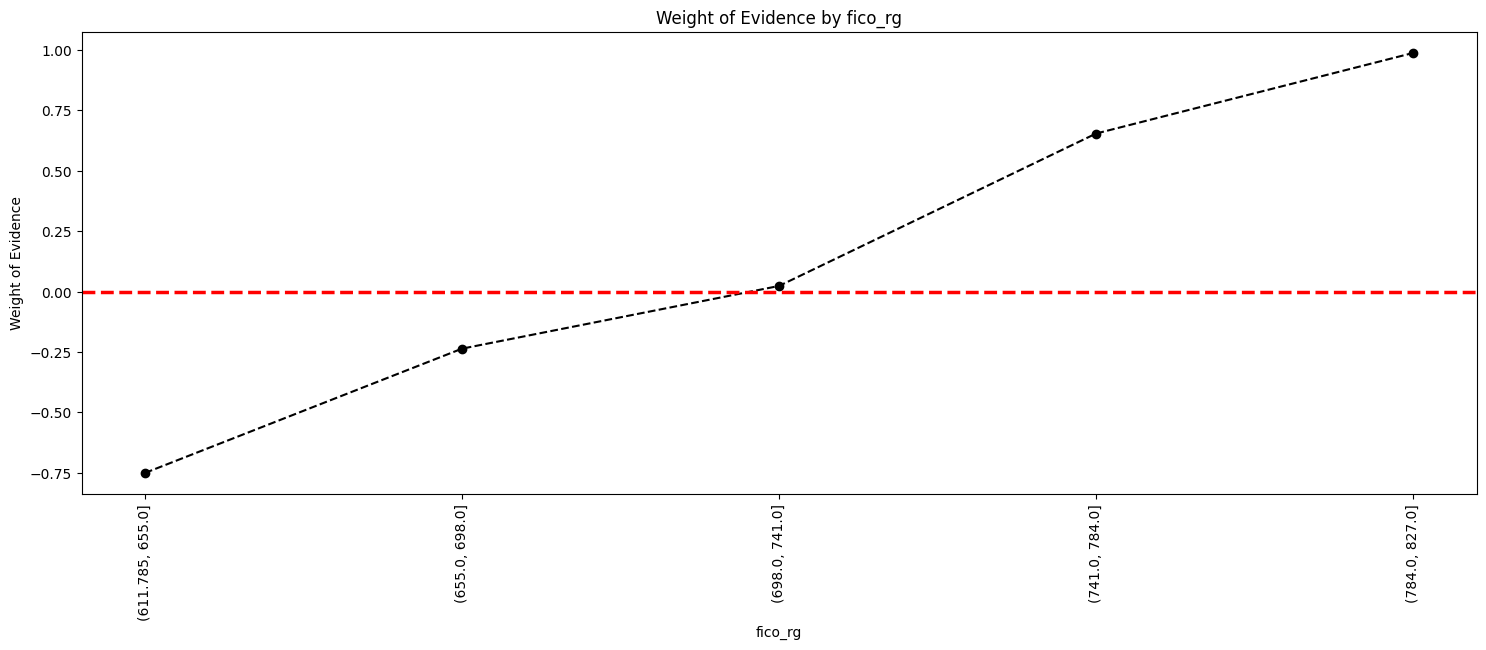

In [256]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

#### revol_util

In [272]:
"""
Revol util ranges
------------------------
(0, 25]
(25, 50]
(50, 70] (Base)
(70, 95]
(95, inf]
"""

num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

num_df['revol_util_rg'] = pd.cut(num_df.revol_util, 5)
temp_df = woe_num_discrete(num_df, 'revol_util_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,9,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,revol_util_rg,n_obs,n_good,n_bad,WoE,diff_prop_good,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(-0.119, 23.8]",1815,1598,217,0.338340,nan,26.23,26.23,1,1,1,1
1,"(23.8, 47.6]",1726,1469,257,0.084990,0.029340,24.95,51.18,1,1,1,1
2,"(47.6, 71.4]",1663,1379,284,-0.078131,0.021877,24.04,75.21,1,1,1,1
3,"(71.4, 95.2]",1430,1142,288,-0.280695,0.030623,20.67,95.88,1,1,1,1
4,"(95.2, 119.0]",285,224,61,-0.357499,0.012636,4.12,100.00,0,0,1,1


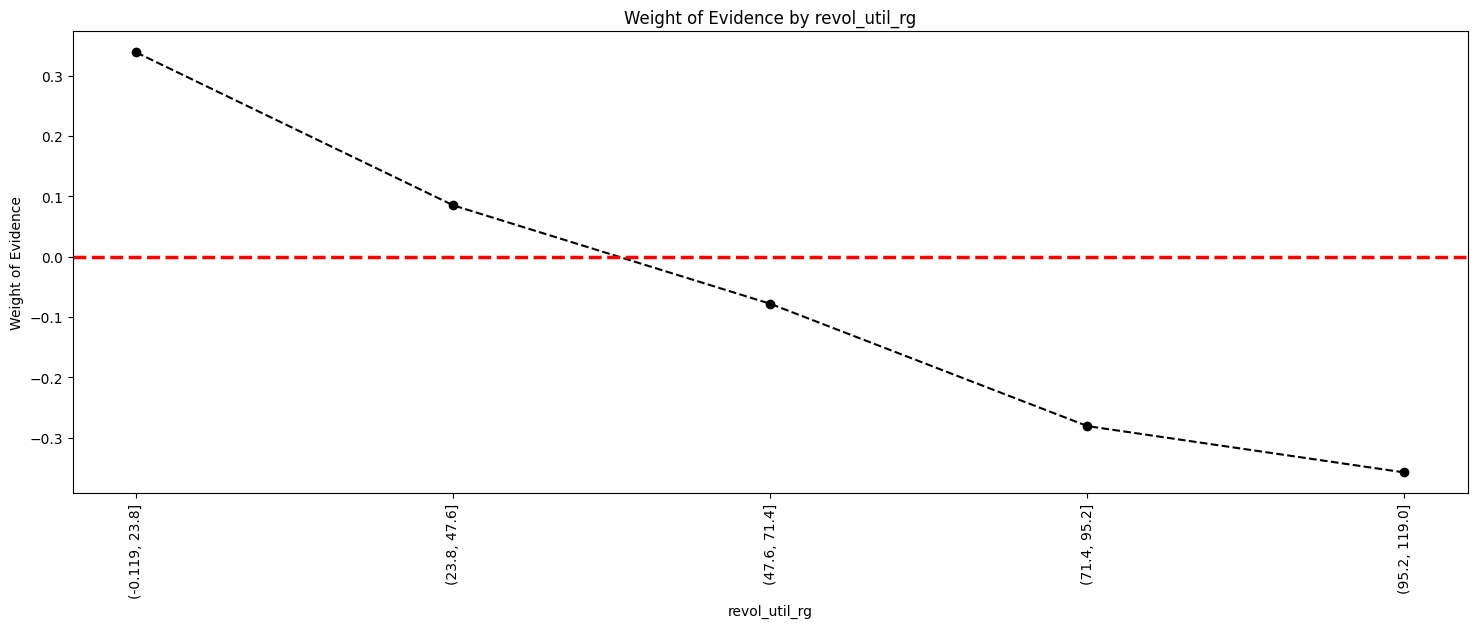

In [273]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

#### inq_last_6mths

In [287]:
"""
Revol util ranges
------------------------
0
1-2
2+
"""

num_df = x_train.select_dtypes(exclude=['object', 'category']).copy()
target = y_train.copy()
target = target + 1
target.loc[target == 2] = 0

num_df2_temp = num_df.loc[(num_df.inq_last_6mths < 2), :].copy()
num_df2_temp['inq_last_6mths_rg'] = pd.cut(num_df2_temp.inq_last_6mths, 2)
temp_df = woe_num_discrete(num_df2_temp, 'inq_last_6mths_rg', target)

# num_df['inq_last_6mths_rg'] = pd.cut(num_df.inq_last_6mths, 2)
# temp_df = woe_num_discrete(num_df, 'inq_last_6mths_rg', target)
temp_df['%_n_obs'] = (temp_df.n_obs / temp_df.n_obs.sum()) * 100
temp_df['%_n_obs_cum'] = temp_df['%_n_obs'].cumsum()
temp_df['val_5%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.05, 1, 0)
temp_df['val_10%'] = np.where(temp_df.n_obs >= num_df.shape[0] * 0.1, 1, 0)
temp_df['val_good'] = np.where(temp_df.n_good > 0, 1, 0)
temp_df['val_bad'] = np.where(temp_df.n_bad > 0, 1, 0)

(temp_df
 .iloc[:, [0,1,4,5,8,9,12,13,14,15,16,17]]
 .style
 .format({'n_good': '{0:.0f}',
          'n_bad': '{0:.0f}',
          '%_n_obs_cum': '{0:.2f}',
          '%_n_obs': '{0:.2f}'
          })
 .bar(subset=['%_n_obs'], color='purple')
 )

,inq_last_6mths_rg,n_obs,n_good,n_bad,WoE,diff_prop_good,%_n_obs,%_n_obs_cum,val_5%,val_10%,val_good,val_bad
0,"(-0.001, 0.5]",2653,2333,320,0.116481,nan,59.94,59.94,1,1,1,1
1,"(0.5, 1.0]",1773,1502,271,-0.157675,0.032230,40.06,100.00,1,1,1,1


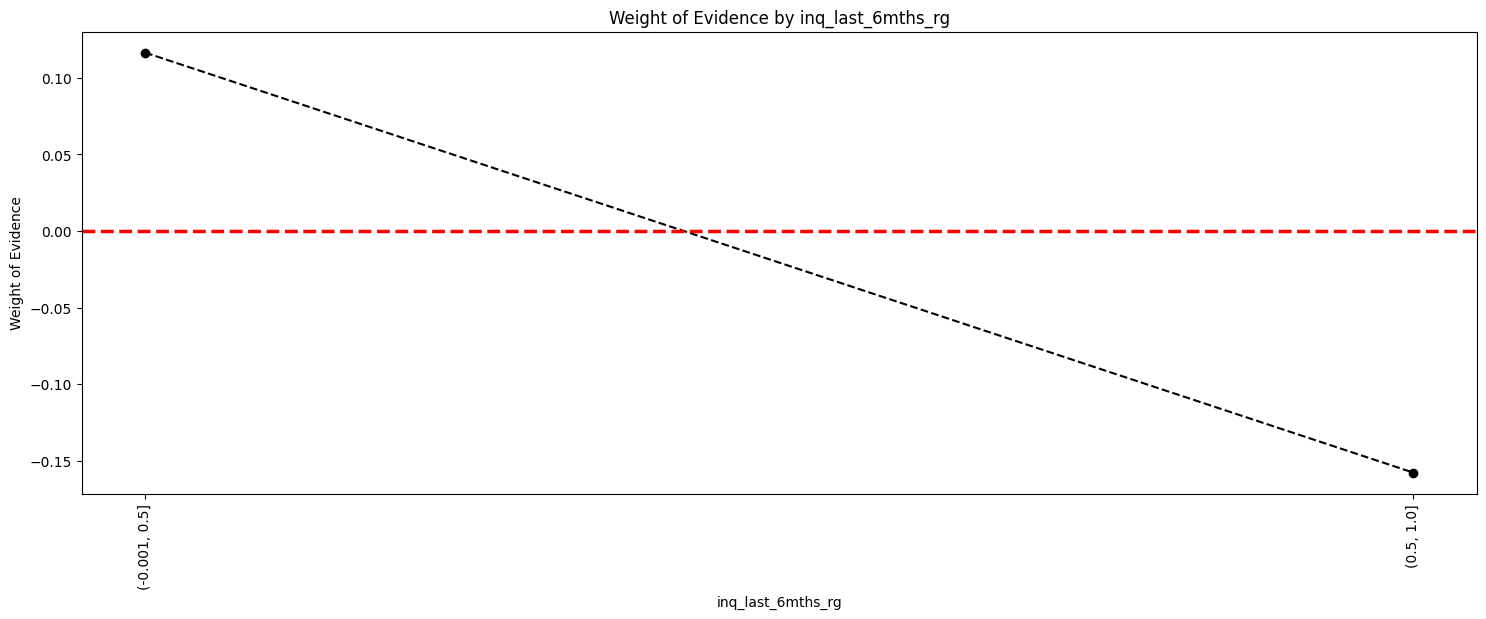

In [288]:
plot_by_woe(temp_df, rotation_of_x_axis_labels = 90)

## Save Train and Test sets

In [344]:
#======================
# Final datasets
#======================

# Training
cols = ['credit_policy', 'int_rate', 'installment', 'dti', 
        'fico', 'revol_util', 'inq_last_6mths', 'log_annual_inc',
        'purpose']
x_train = x_train.loc[:, cols]
x_train['maha_out'] = outlier_df.maha_out

# Drop outliers
x_train = x_train.loc[x_train.maha_out == 0, cols]
# Add target variable
x_train['default'] = y_train

# Validation
x_val = x_val.loc[:, cols]
x_val['default'] = y_val

# Test
x_test = x_test.loc[:, cols]
x_test['default'] = y_test

In [366]:
# Training set
x_train.to_parquet('../data/processed/training.gzip', compression='gzip')
# Validation set
x_val.to_parquet('../data/processed/validation.gzip', compression='gzip')
# Test set
x_test.to_parquet('../data/processed/test.gzip', compression='gzip')